# chi$^2$ fitting of synthetic spectra to spectra of NGC 7006

In this program we will be computing velocities of stars in the Milky Way globular cluster NGC 7006 with Keck DEIMOS data. We will be fitting a synthetic model spectrum from the PHOENIX library to determine velocities with $\chi^2$ minimization. The data is already fully reduced and all Keck data is publically available on the Keck Data Archive (KOA) website.

<img src='Chi2_MCMC_DATA/chi2_spectrum_fit.png' width="2000">

In [1]:
import numpy as np
from numba import njit
import scipy.ndimage as scipynd
from astropy.io import fits
import matplotlib.pyplot as plt
from tqdm import tqdm

## Loading the data
The fits file contains the spectras of many different stars in the globular cluster. In this program we will choose stars 121, 135, and 157.

In [23]:
def load_fits(file):
    '''
    load fits file into python as hdu object
    Parameter
    ---------
    file: string
        path to data fits file
    Returns
    -------
    hdu: astropy.io.fits.hdu.hdulist.HDUList
        astropy fits hdu object containing header and data
    '''
    
    hdu = fits.open(file)
    
    return hdu

def get_data(star):
    '''
    extracts wavelengths, counts, and inverse variance for a given star's spectrum
    Parameters
    ----------
    star : astropy.io.fits.hdu.table.BinTableHDU
        HDU containing the spectral data of a star from a FITS file.
    Returns
    -------
    wavelength: np.ndarray[np.float64]
        wavelength values (in Å) within the range 8300-8800 Å
    counts: np.ndarray[np.float64]
        flux counts corresponding to the selected wavelength range
    inverse_var: np.ndarray[np.float64]
        inverse variance (1/σ²) of the flux counts for error estimation
    '''
    
    mask = (star.data['OPT_WAVE'] > 8300) & (star.data['OPT_WAVE'] < 8800)
    wavelength = star.data['OPT_WAVE'][mask].astype(np.float64)
    counts = star.data['OPT_COUNTS'][mask].astype(np.float64)
    inverse_var = star.data['OPT_COUNTS_IVAR'][mask].astype(np.float64)
    
    return wavelength, counts, inverse_var

file = 'Chi2_MCMC_DATA/spec1d_DE.20110603.45055-n7006a_DEIMOS_2011Jun03T123053.021.fits'
hdu = load_fits(file)
star_ids = [121, 135, 157]
colors = ['purple', 'mediumvioletred', 'mediumslateblue']

## Plotting Spectra

In [24]:
def create_figure(figsize):
    '''
    template for matplotlib.pyplot plots
    Parameters
    ----------
    figsize: tuple
        sets the figure size of a matplotlib plot
    Example
    -------
        figsize = (5,5)
    '''
    plt.figure(figsize = figsize)
    plt.rcParams['font.family'] = 'courier new'
    plt.rcParams['mathtext.default'] = 'regular'
    plt.rcParams['axes.linewidth'] = 0.5
    plt.minorticks_on()
    plt.tick_params(axis='both', length=3, direction='in', which='both', right=True, top=True)
    
def plot_spectra(wavelength, flux, color, label, **kwargs):
    '''
    generate spectra plot of flux as a function of wavelength
    Parameters
    ----------
    wavelength: np.ndarray[np.float64]
        wavelength values (in Å) within the range 8300-8800 Å
    flux: np.ndarray[np.float64]
        flux counts corresponding to the selected wavelength range
    color: string
        matplotlib.pyplot color for the spectra plot
    label: string
        spectra plot label
    kwargs
    ------
    model: list of np.ndarray[np.float64] and str
        list of length 2 containing the model flux and model label (str}.
        this assumes the model flux shares the same wavelength array as 
        'wavelength'
    lines: boolean
        if True, will plot CaII line markers
    vshift: float
        by default is 0, shifts the CaII line markers by a velocity
        using δλ = λ * 𝜈/c
    Returns
    -------
        wavelength v flux plot of spectrum
    '''

    # define figure
    create_figure((14,4))    
    rm_cosmic_hits = (flux < np.percentile(flux, 99))
    # compute ymin and ymax
    mask = (wavelength[rm_cosmic_hits] > 8300) & (wavelength[rm_cosmic_hits] < 8800)
    diff = np.max(flux[rm_cosmic_hits][mask]) - np.min(flux[rm_cosmic_hits][mask])
    plt.xlim(8300, 8800)
    plt.ylim(np.min(flux[rm_cosmic_hits][mask])-diff/16, np.max(flux[rm_cosmic_hits][mask])+diff/30)
    # plot spectrum
    plt.plot(wavelength[rm_cosmic_hits], flux[rm_cosmic_hits], lw = 1.0, label = label, c = color, alpha = 0.48)
    # plot model spectrum
    if 'model' in kwargs:
        model = kwargs['model']
        plt.plot(wavelength, model[0], lw=1.5, color='darkslateblue', label=model[1])
    # plot calcium II absorption line markers
    if 'lines' in kwargs:
        CaII_lines = [8500.36, 8544.44, 8664.52] # [Å]
        vshift = 0
        if 'vshift' in kwargs:
            vshift = kwargs['vshift']
        for line in CaII_lines:
            line *= (1 + vshift/2.997924e5)
            plt.axvline(x=line, color='black', ls='dashed', lw=1, alpha=0.5)
            plt.text(line+3, np.min(flux[rm_cosmic_hits][mask])+diff/22, 'CaII', fontsize = 10, fontname = 'courier new')

    # label axes
    plt.xlabel('\u03BB [Å]', size=17)
    plt.ylabel(r'$\phi$', size=18)
    plt.legend(loc='lower left')
    plt.show()

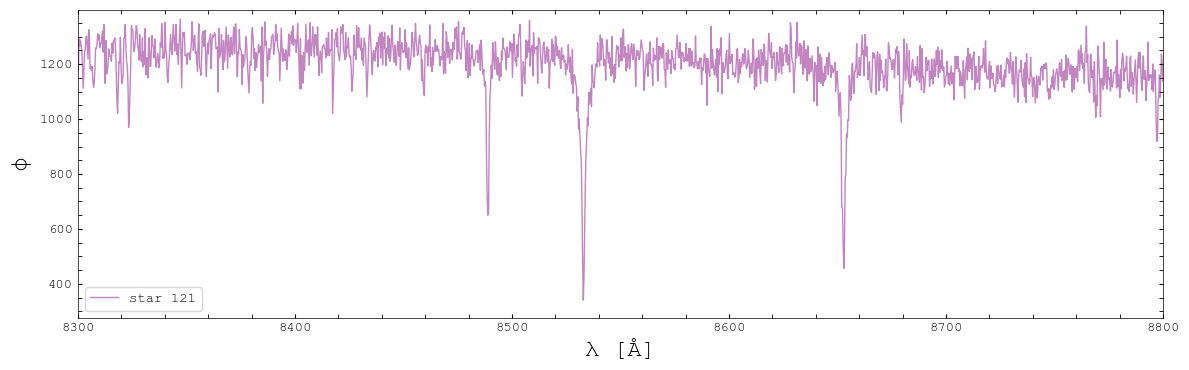

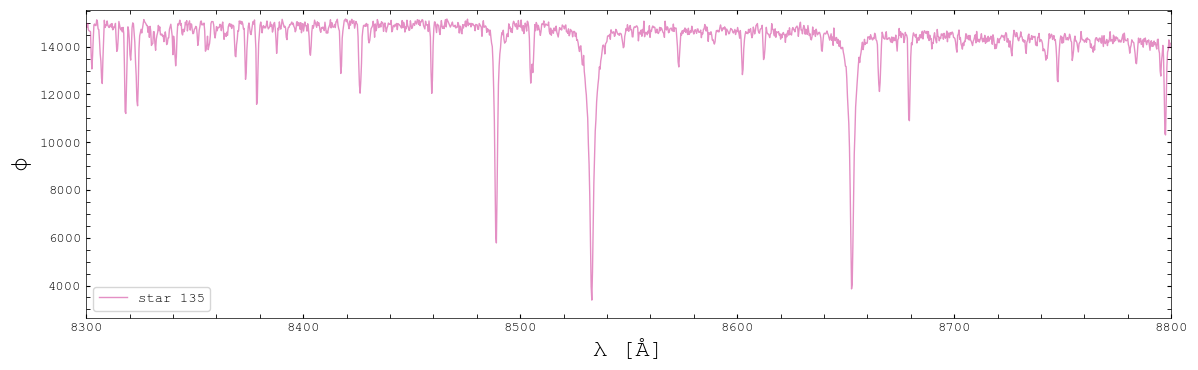

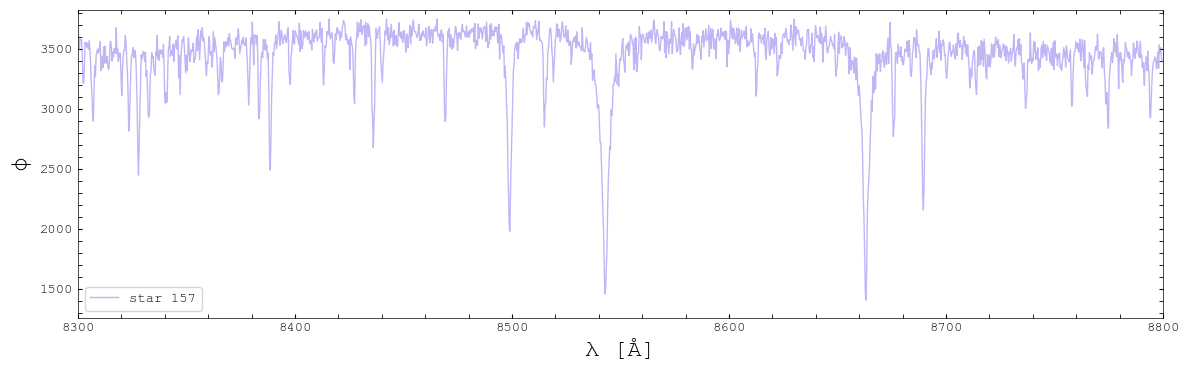

In [25]:
for i, star_id in enumerate(star_ids):
    star_wave, star_flux, star_var = get_data(hdu[star_id])
    plot_spectra(star_wave, star_flux, colors[i], f'star {star_id}')

## Reading in the sythetic spectra and smoothing
To determine accurate velocities, we turn to 'template fitting' where a spectrum with a known velocity is compared to our unknown science spectrum. These template spectrums can either be empiricial (an observed spectrum of a standard star where the velocity is already known) or synthetic (numerically computed from stellar models) spectras. The model is from the PHOENIX library: https://phoenix.astro.physik.uni-goettingen.de/

The spectrum is converted to vacuum wavelengths and then smoothed with a gaussian filter. The DEIMOS spectral lines are well fit by a Gaussian with a 1-$\sigma$ line width that is roughly 0.5 Angstrom. The synthetic spectra have resolution of 0.02 Angstrom. Thus, we need to smooth the sythetic spectra with a Gaussian kernal that is 0.5/0.02 = 25 pixels.   

In [27]:
def read_synthetic_spectrum(file):
    '''
    load synthetic template file into python and convert to vacuum wavelengths
    '''
    with fits.open(file) as hdu:
        data = hdu[1].data   
    synthetic_flux = np.array(data['flux']).flatten()
    air_wavelengths = np.exp((data['wave']).flatten())
    # convert air wavelengths to vacuum
    s = 10**4 / air_wavelengths
    n = 1.0 + 0.00008336624212083 + \
             (0.02408926869968 / (130.1065924522 - s**2)) +\
             (0.0001599740894897 / (38.92568793293 - s**2))

    synthetic_wave  = air_wavelengths*n
    
    return synthetic_wave, synthetic_flux

# read in synthetic spectra and smooth flux
synthetic_spectra = 'Chi2_MCMC_DATA/dmost_lte_5500_3.0_-1.0_.fits'
syn_wave, syn_flux = read_synthetic_spectrum(synthetic_spectra)
syn_flux_smooth = scipynd.gaussian_filter1d(syn_flux, 25, truncate = 3)

The synthetic model covers the range of 6000 to 9600 Angstroms. Zooming in onto 8300-8800 Angstroms and smoothing the syntetic spectra, our model starts to resemble our stellar spectra.

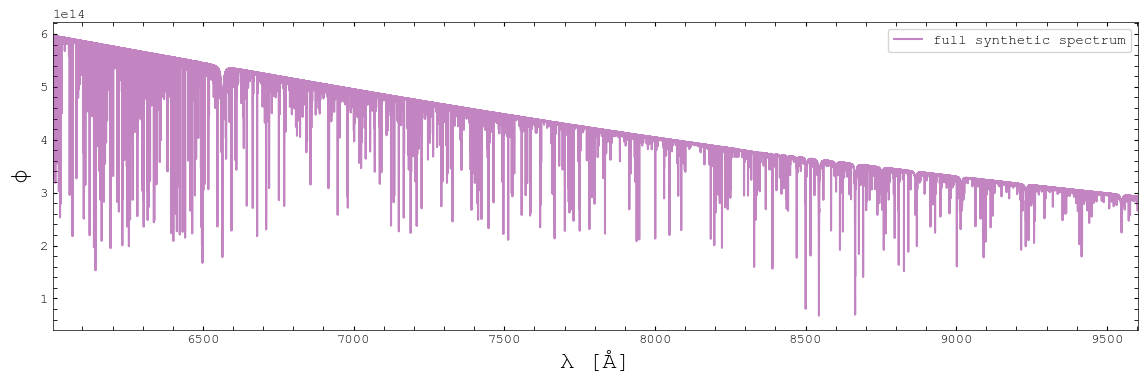

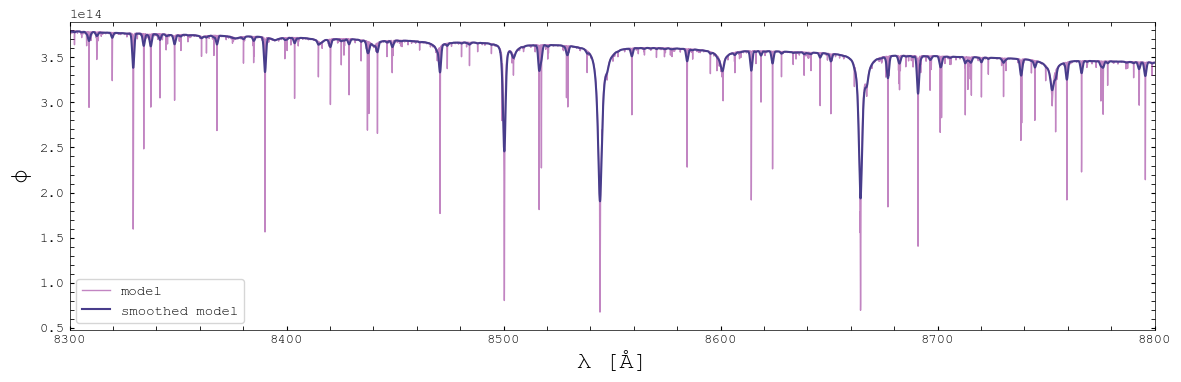

In [28]:
create_figure((14,4))
plt.plot(syn_wave, syn_flux, c='purple', alpha=0.48, label='full synthetic spectrum')
plt.xlabel('\u03BB [Å]', size=17)
plt.ylabel(r'$\phi$', size=18)
plt.xlim(syn_wave.min(), syn_wave.max())
plt.legend()
plt.show()
model = [syn_flux_smooth, 'smoothed model']
plot_spectra(syn_wave, syn_flux, 'purple', 'model', model=model)

## Fitting the Continuum

We will fit the overall continuum of the synthetic spectrum by fitting a cubic polynomial. The synthetic fluxes are interpolated onto the science wavelengths to account for the science data not covering the whole range of the synthetic model. We also need to remove the absorption lines in the science spectrum to properly fit the model to the continuum. Notice how the synthetic spectrum does not match with the stellar spectrum, due to the stars' velocities.


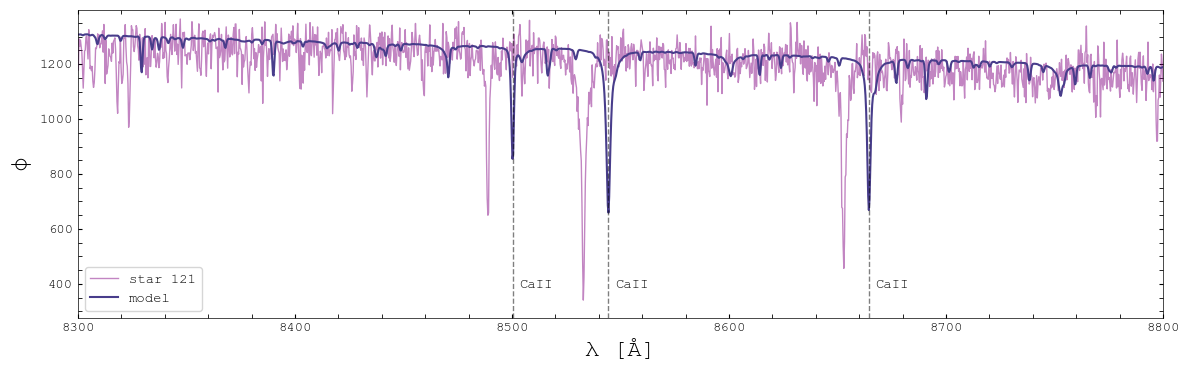

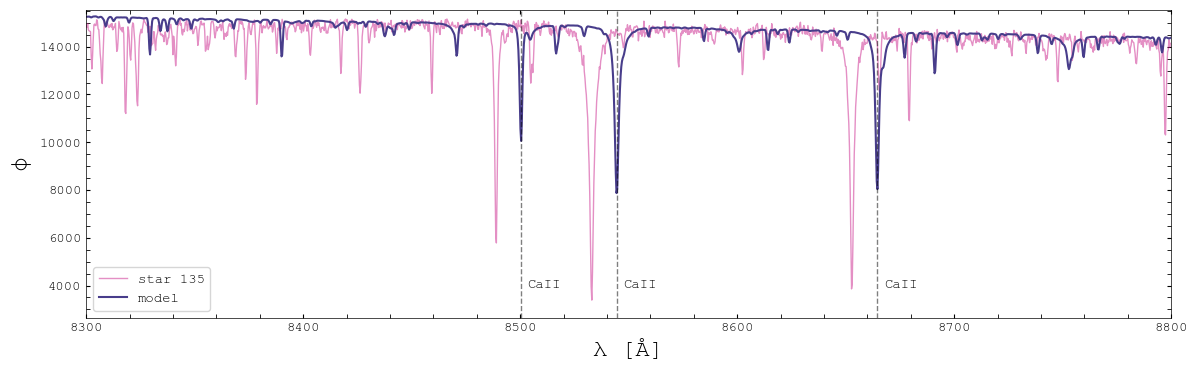

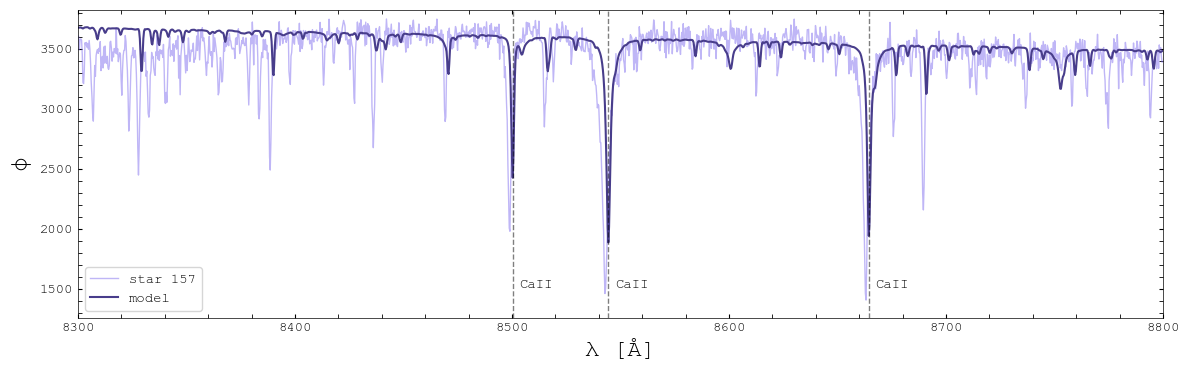

In [7]:
def match_continuum(syn_wave, syn_flux, star_wave, star_flux):
    # interpolate synthetic spectrum to science wavelengths
    interpolated_flux = np.interp(star_wave, syn_wave, syn_flux)
    # compute ratio between star flux and model
    # this ratio maps by how much syn_flux != star_flux
    continuum = star_flux/interpolated_flux
    # mask out deepest lines
    remove_lines = (continuum > np.percentile(continuum, 20)) & (continuum < np.percentile(continuum, 99))
    # compute transformation to fit synthetic spectrum continuum onto science
    # this transformation takes in a wavelength and returns the coefficient
    # that scales syn_flux to match star flux
    poly = np.polyfit(star_wave[remove_lines], continuum[remove_lines], 1)
    transform = np.poly1d(poly)
    model_flux_matched = interpolated_flux * transform(star_wave)
    
    return model_flux_matched

for i, star_id in enumerate(star_ids):
    star_wave, star_flux, star_var = get_data(hdu[star_id])
    model_flux = match_continuum(syn_wave, syn_flux_smooth, star_wave, star_flux)
    model = [model_flux, 'model']
    plot_spectra(star_wave, star_flux, colors[i], f'star {star_id}', model=model, lines=True)
    

## Computing velocity shift
The three deepest lines correspond to the CaII lines at 8500.36, 8544.44, and 8664.52 Angstroms. We can determine the velocity shift in the star spectrum using a one parameter $\chi^2$ minimization where we shift the syntethic wavelength with $\delta \lambda = \lambda * v/c$ before matching the continuum.

In [8]:
def compute_chi2(star_flux, star_var, model_flux):
    '''
    Computes the chi-squared (χ²) goodness-of-fit between observed and model spectra.
    The chi-squared statistic is calculated as the sum of squared residuals (observed - model),
    weighted by the inverse variance (1/σ²) of the observed flux. This measures how well the
    model fits the data, accounting for observational uncertainties.

    Parameters
    ----------
    star_flux: np.ndarray[np.float64] 
        N shaped array of observed stellar flux values
    star_var np.ndarray[np.float64]
        N shaped array of inverse variances (σ²) of the observed flux
    model_flux: np.ndarray[np.float64] 
        N shaped array of synthetic model fluxes

    Returns
    -------
    chi2: float
        The computed χ² value
    '''
    chi2 = np.sum( star_var * (star_flux - model_flux)**2 )
    
    return chi2

100%|█████████████████████████████████████| 2400/2400 [00:01<00:00, 2194.79it/s]


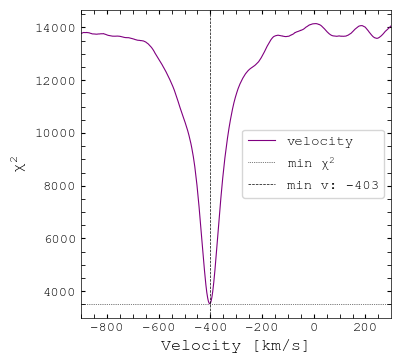

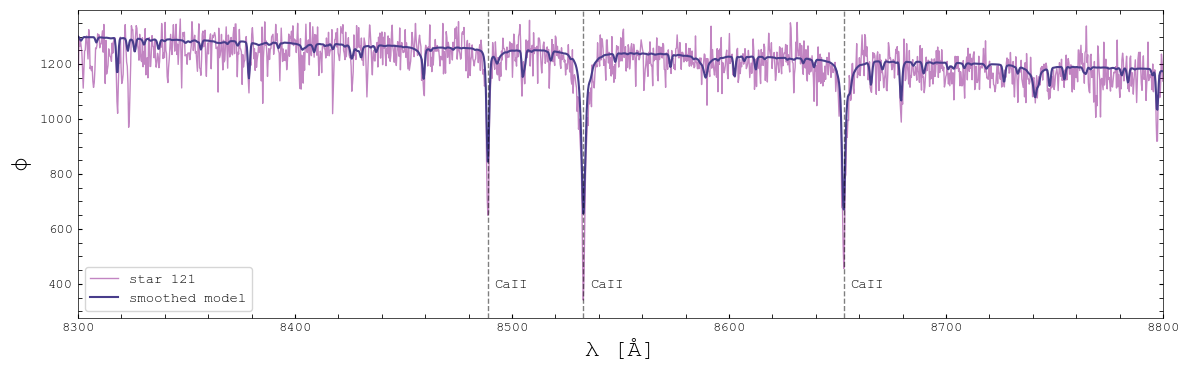

100%|█████████████████████████████████████| 2400/2400 [00:01<00:00, 2138.05it/s]


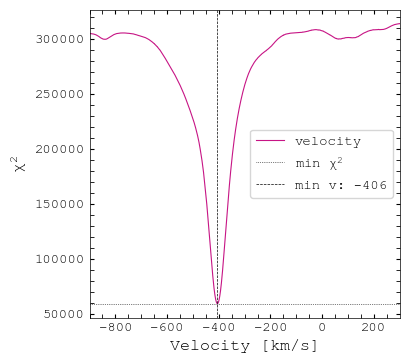

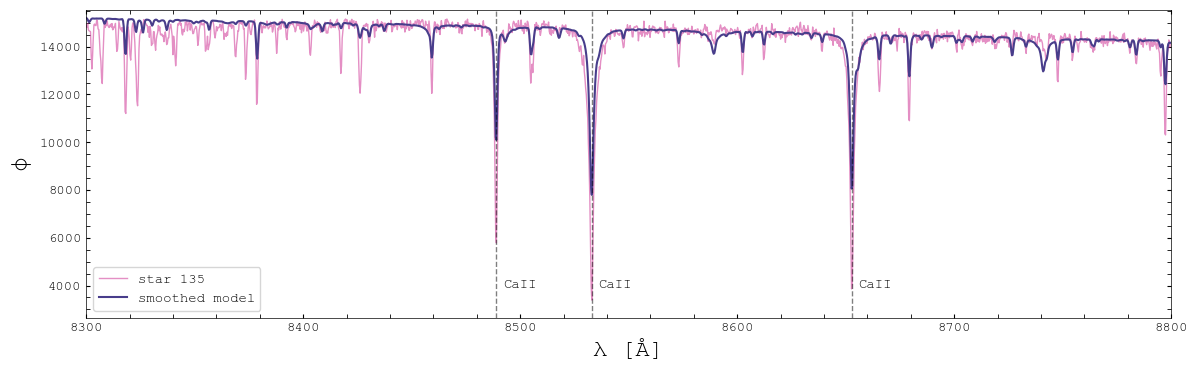

100%|█████████████████████████████████████| 2400/2400 [00:01<00:00, 2114.75it/s]


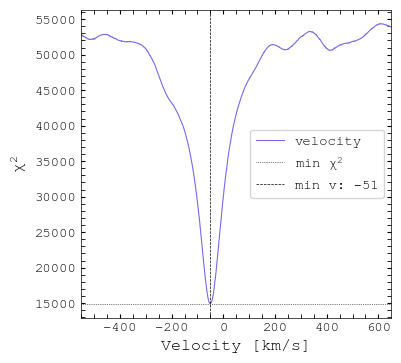

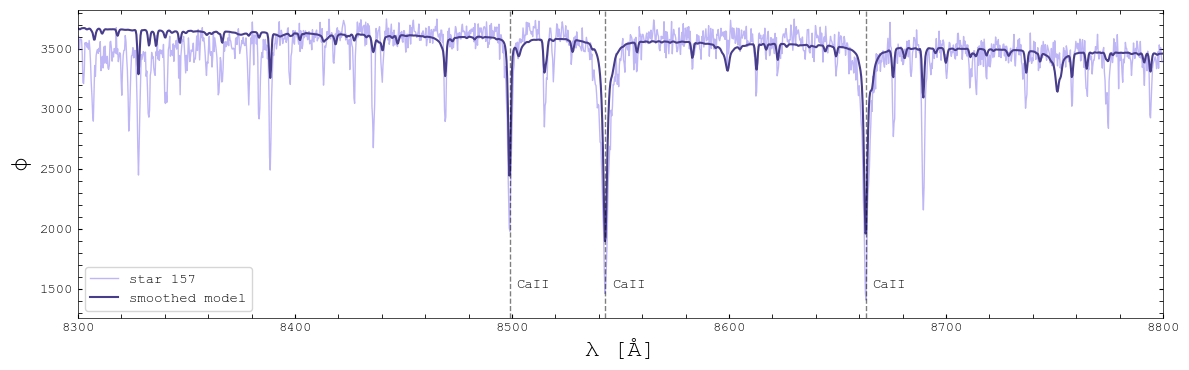

In [9]:
# speed of light in km/s
c = 2.997924e5
# initial velocity guesses
vel_guess = [-400, -400, -50]
# number of stars
N_stars = len(star_ids)
# grid of velocity values for each star 
vel_grid = np.tile(np.arange(-500, 700, 0.5), (N_stars, 1))
# allocate array for chi² values
chi2_grid = np.zeros((N_stars, vel_grid.shape[1]))
# smooth template
syn_flux_smooth = scipynd.gaussian_filter1d(syn_flux, 25, truncate = 3)

# loop through each star
for i, star_id in enumerate(star_ids):
    star_wave, star_flux, star_var = get_data(hdu[star_id])
    # shift velocity grid by guess value
    vel_grid[i, :] += vel_guess[i]
    
    for j in tqdm(range(vel_grid.shape[1])):
        v = vel_grid[i, j]
        # shift synthetic flux by velocity guess
        shifted_wave = syn_wave * (1 + v/c)
        # match continuum
        model_flux = match_continuum(shifted_wave, syn_flux_smooth, star_wave, star_flux)
        # compute chi²
        chi2_grid[i, j] = compute_chi2(star_flux, star_var, model_flux)

    # find index of minimum chi² value
    idx_min = np.argmin(chi2_grid[i,:])
    # find minimum chi² value
    chi2_min = chi2_grid[i,:][idx_min]
    # find velocity value associated with minimum chi² value
    vel_min = vel_grid[i,:][idx_min]
    
    # shift synthetic wavelengths by best fit velocity
    shifted_wave = syn_wave * (1 + vel_min/c)
    # match continuums
    model_flux = match_continuum(shifted_wave, syn_flux_smooth, star_wave, star_flux)

    # plot chi2 
    create_figure((4,4))
    plt.plot(vel_grid[i,:], chi2_grid[i,:], lw = 0.8, color = colors[i], label = 'velocity')
    plt.axhline(y = chi2_min, color = 'black', lw = 0.5, ls = 'dotted', label = r'min $\chi^{2}$')
    plt.axvline(x = vel_min, color = 'black', ls = 'dashed', lw = 0.5, label = 'min v: {:.0f}'.format(vel_min))
    plt.xlabel(r'Velocity [km/s]', size = 12)
    plt.ylabel(r'$\chi^{2}$', size = 12)
    plt.xlim(np.min(vel_grid[i,:]), np.max(vel_grid[i,:]))
    plt.legend(loc = 'best', prop = {'family': 'courier new', 'size': 10})
    plt.show()

    # plot star spectrum with shifted model
    model = [model_flux, 'smoothed model']
    plot_spectra(star_wave, star_flux, colors[i], lines=True, vshift=vel_min, label=f'star {star_id}', model=model)

## 2 parameter Chi$^2$
We can do a 2 parameter $\chi^2$ fit by fitting for both smoothing length and velocity. We first shift the velocity and then apply the gaussian smoothing.

100%|███████████████████████████████████████████| 60/60 [00:12<00:00,  4.74it/s]


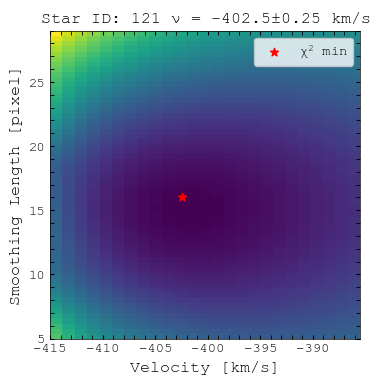

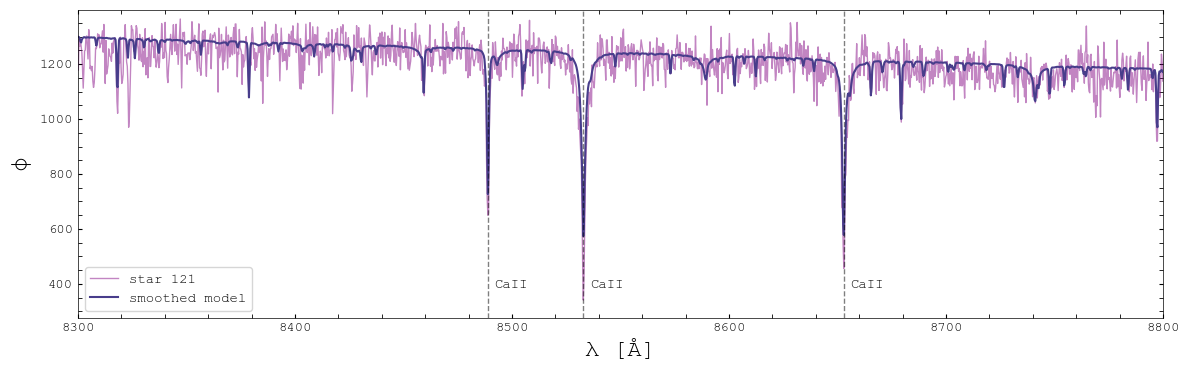

100%|███████████████████████████████████████████| 60/60 [00:12<00:00,  4.64it/s]


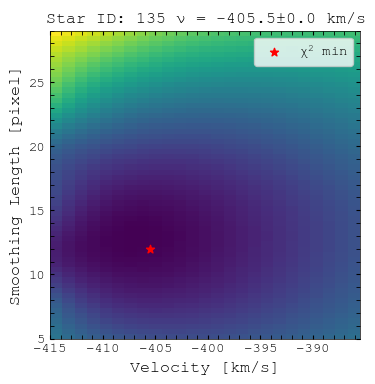

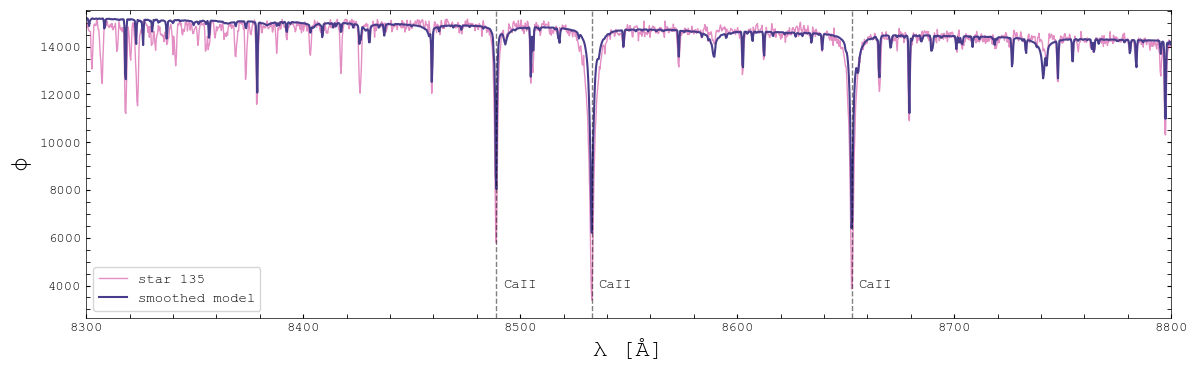

100%|███████████████████████████████████████████| 60/60 [00:12<00:00,  4.71it/s]


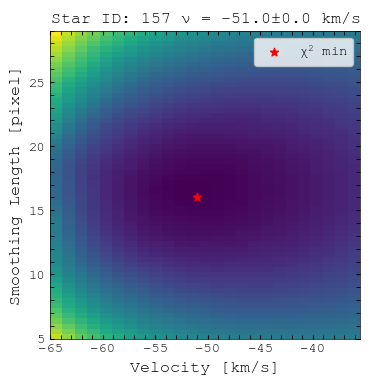

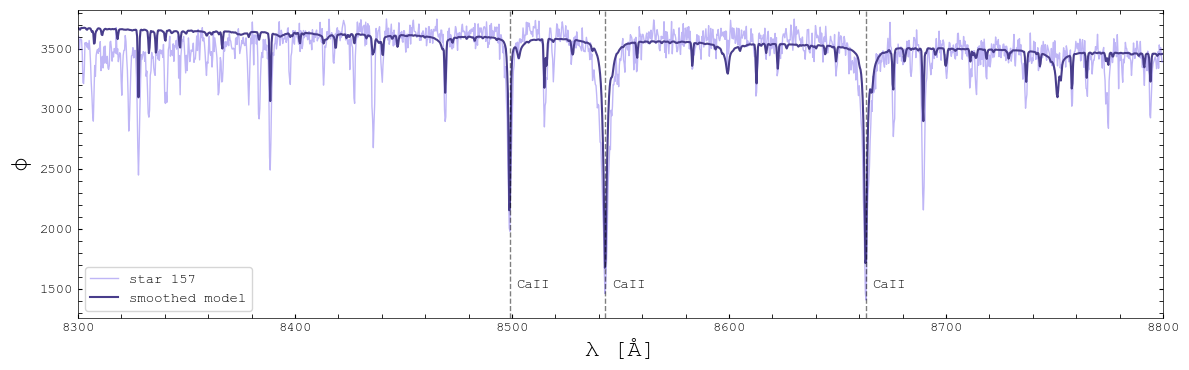

In [12]:
# speed of light in km/s
c = 2.997924e5
# initial velocity guesses
vel_guess = [-400, -400, -50]
# number of stars
N_stars = len(star_ids)
# grid of velocity values for each star 
vel_grid = np.tile(np.arange(-15, 15, 0.5), (N_stars, 1))
# grid of smoothing lengths
smooth_grid = np.arange(5, 30, 1)
# allocate array for chi² values, and minimum vel and smoothing values
chi2_grid = np.zeros((N_stars, smooth_grid.shape[0]*vel_grid.shape[1]))
vel_min, v_errors, smooth_min = [], [], []

# loop through each star
for i, star_id in enumerate(star_ids):
    star_wave, star_flux, star_var = get_data(hdu[star_id])
    # shift velocity grid by guess value
    vel_grid[i, :] += vel_guess[i]
    vels, smooths, chi = [], [], []
    counter = 0
    for j in tqdm(range(vel_grid.shape[1])):
        v = vel_grid[i, j]
        for k, smooth_val in enumerate(smooth_grid):

            # shift wavelength by velocity
            shifted_wave = syn_wave * (1 + v/c)
            # smooth synthetic flux
            syn_flux_smooth = scipynd.gaussian_filter1d(syn_flux, smooth_val, truncate=3)
            # match continuum
            model_flux = match_continuum(shifted_wave, syn_flux_smooth, star_wave, star_flux)

            chi2_grid[i, counter] = compute_chi2(star_flux, star_var, model_flux)

            vels = np.append(vels, v)
            smooths = np.append(smooths, smooth_val)
            chi = np.append(chi, chi2_grid[i, counter])
            counter += 1
  
    # flattened index of minimum chi² value
    idx_min = np.argmin(chi2_grid[i])
    idx_min = np.argmin(chi)
    # minimum chi² value
    chi2_min = chi[idx_min]
    # compute error on minimum chi² value
    # check if each chi² value < minimum chi² + 1.0
    err_mask = chi < (chi2_min + 1.0)
    # find 1σ error
    v_errors.append( (np.max(vels[err_mask]) - np.min(vels[err_mask])) / 2.0 )
    
    # compute velocity min and smooth min
    vel_min.append(vels[idx_min])
    smooth_min.append(smooths[idx_min])

    # shift synthetic wavelengths by best fit velocity
    shifted_wave = syn_wave * (1 + vel_min[i]/c)
    # smooth synthetic flux
    syn_flux_smooth = scipynd.gaussian_filter1d(syn_flux, smooth_min[i])
    # match continuums
    model_flux = match_continuum(shifted_wave, syn_flux_smooth, star_wave, star_flux)
    
    # plot chi² map
    create_figure((4,4))
    extent = (np.min(vel_grid[i]), np.max(vel_grid[i]), np.min(smooth_grid), np.max(smooth_grid))
    plt.imshow(chi2_grid[i].reshape(vel_grid[i].shape[0], smooth_grid.shape[0]), 
               aspect='auto', origin='lower', extent = extent)
    plt.scatter(vel_min[i], smooth_min[i], marker='*', c='r', label=r'$\chi^2$ min')
    plt.xlabel(r'Velocity [km/s]', size = 12)
    plt.ylabel('Smoothing Length [pixel]', size = 12)
    plt.title(fr'Star ID: {star_id} $\nu$ = {vel_min[i]}±{v_errors[i]} km/s')
    plt.legend()
    plt.show()
    
    # plot spectrum and best fit model
    model = [model_flux, 'smoothed model']
    plot_spectra(star_wave, star_flux, colors[i], lines=True, vshift=vel_min[i], label=f'star {star_id}', model=model)

## Velocity analysis
Now that the velocities are computed for each star, we can compare with the velocity of NGC 7006 from SIMBAD to determine if the stars are part of the cluster or not.

In [13]:
print(f'NGC 7006 velocity: {-383.2} ± {0.6} [km/s]')
for i, star_id in enumerate(star_ids):
    print(f'star {star_id} velocity: {vel_min[i]} ± {v_errors[i]} [km/s]')

NGC 7006 velocity: -383.2 ± 0.6 [km/s]
star 121 velocity: -402.5 ± 0.25 [km/s]
star 135 velocity: -405.5 ± 0.0 [km/s]
star 157 velocity: -51.0 ± 0.0 [km/s]


In [14]:
print(f'NGC 7006 redshift z: {-0.001277} ± {0.000002}')
for i, star_id in enumerate(star_ids):
    z = np.sqrt((1 + vel_min[i] / c) / (1 - vel_min[i] / c)) - 1
    print(f'star {star_id} redshift z: {z:.4}')

NGC 7006 redshift z: -0.001277 ± 2e-06
star 121 redshift z: -0.001342
star 135 redshift z: -0.001352
star 157 redshift z: -0.0001701


#### We can conclude that stars 121 and 135 are apart of NGC 7006 but star 157 is likely a background star!
Plotting each spectrum together we can clearly see that the the CaII lines match stars 121 and 135 but not 157 (for a given velocity shift). We can also conclude that our synthetic spectra is not a very good model for our star spectra since the continuum and emission lines do not match very well!

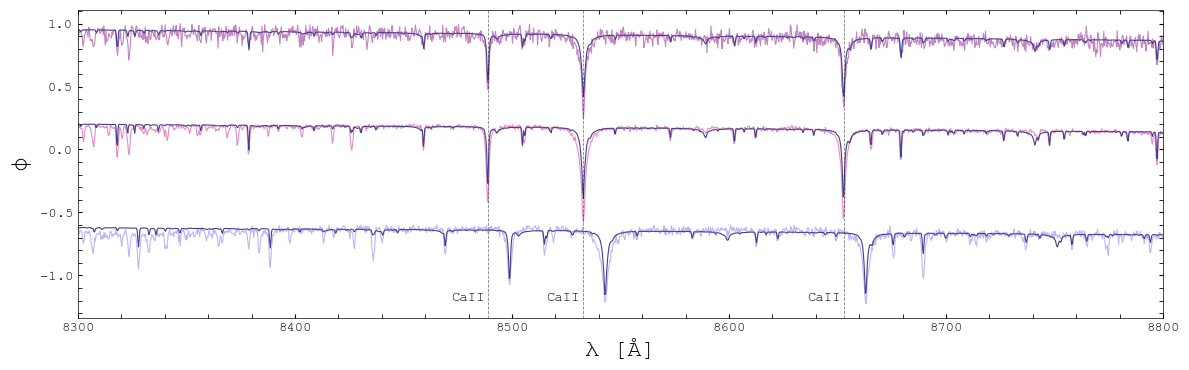

In [15]:
create_figure((14,4))
mask = (star_wave > 8300) & (star_wave < 8800)
diff = np.max(star_flux[mask]) - np.min(star_flux[mask])
plt.xlim(8300, 8800)
CaII_lines = [8500.36, 8544.44, 8664.52] # [Å]
for i, star_id in enumerate(star_ids):
    star_wave, star_flux, star_var = get_data(hdu[star_id])
    msk = (star_flux < np.percentile(star_flux, 99))
    plt.plot(star_wave[msk], star_flux[msk]/np.max(star_flux[msk])-i*.8, c = colors[i], alpha = 0.48, lw = 0.8)
    shifted_wave = syn_wave * (1 + vel_min[i]/c)
    syn_flux_smooth = scipynd.gaussian_filter1d(syn_flux, smooth_min[i])
    model_flux = match_continuum(shifted_wave, syn_flux_smooth, star_wave, star_flux)
    plt.plot(star_wave, model_flux/np.max(star_flux[msk])-i*.8, c = 'darkslateblue', lw = 0.8)
    line = CaII_lines[i] * (1 + vel_min[0]/c)
    plt.axvline(x=line, color = 'black', ls = 'dashed', lw = 0.6, alpha = 0.5)
    plt.text(line-17, -1.2, 'CaII', fontsize = 10, fontname = 'courier new')
    plt.xlabel('\u03BB [Å]', size = 17)
    plt.ylabel(r'$\phi$', size = 18)
#plt.savefig('chi2_spectrum_fit.png', dpi=300, format='png')
plt.show()